In [2]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.signal import butter, sosfiltfilt, find_peaks
from utils import *
import os

%matplotlib inline
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14
np.set_printoptions(threshold=sys.maxsize,
                    suppress=True)

import torch

torch.manual_seed(1)

___
**PREPROCESSING**
___

In [3]:
filenames = os.listdir('../dataset/ble_test/')
labels = [filename.split('.')[0] for filename in filenames]

filenames

['deep_breath.csv',
 'dry_cough.csv',
 'jumping_jack.csv',
 'push_up.csv',
 'random.csv',
 'swallowing.csv',
 'throat_clearing.csv']

DEEP BREATH

IndexError: index 21 is out of bounds for dimension 0 with size 21

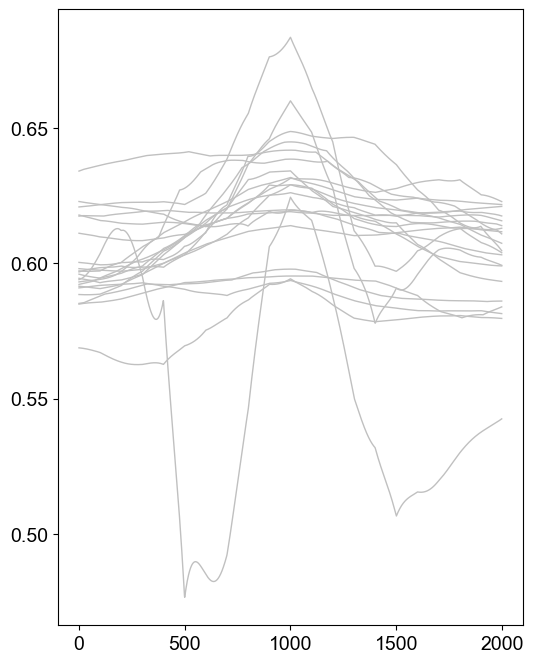

In [10]:
# Load
filename = filenames[0]
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'ble_test', filename), delimiter=',', header=None)
timestamps, c, b, tl, tr, r, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
y = detrend(y, method='butter', fc=2)
r, p, y = despike(r, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, r, p, y])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version

# Butterworth
sos = butter(1, [2, 4], 'bandstop', output='sos', fs=1000)
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)

# Find peaks
peaks, _ = find_peaks(data[:, 0], distance=5000)

# plt.plot(timestamps, data[:, 0])
# plt.plot(peaks, data[peaks, 0], 'x')
# plt.xlim(0, 20000)

# Construct slices
window_width = 2000
expanded_peaks = peak_expand(peaks, window_width, len(timestamps))

slices = []
for idx in range(expanded_peaks.shape[0]):
    slices.append(data[expanded_peaks[idx, :]])
slices = np.array(slices)
slices = torch.tensor(np.transpose(slices, (0, 2, 1)))
# slices.shape

plt.figure(figsize=(6, 8))
for idx in range(22):
    plt.plot(slices[idx, 0, :], 'silver')
plt.plot(torch.mean(slices[:, 0, :], axis=0))

In [92]:
torch.mean(slices[:, 0, :], axis=0).shape

torch.Size([5000])

In [ ]:
import torch
import torch.nn as nn

class DualLSTMModel(nn.Module):
    def __init__(self, input_dim1, input_dim2, hidden_dim, layer_dim, output_dim):
        super(DualLSTMModel, self).__init__()

        # First LSTM layer for the first data type (e.g., photovoltage)
        self.lstm1 = nn.LSTM(input_dim1, hidden_dim, layer_dim, batch_first=True)

        # Second LSTM layer for the second data type (e.g., Euler angles)
        self.lstm2 = nn.LSTM(input_dim2, hidden_dim, layer_dim, batch_first=True)

        # Fully connected layer for classification
        # The input dimension is doubled since we concatenate the outputs
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

        # LogSoftmax for the output layer
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):
        # Initialize hidden state for both LSTMs
        h01 = torch.zeros(layer_dim, x1.size(0), hidden_dim).requires_grad_().to(device)
        c01 = torch.zeros(layer_dim, x1.size(0), hidden_dim).requires_grad_().to(device)

        h02 = torch.zeros(layer_dim, x2.size(0), hidden_dim).requires_grad_().to(device)
        c02 = torch.zeros(layer_dim, x2.size(0), hidden_dim).requires_grad_().to(device)

        # Forward pass through first LSTM
        out1, _ = self.lstm1(x1, (h01.detach(), c01.detach()))

        # Forward pass through second LSTM
        out2, _ = self.lstm2(x2, (h02.detach(), c02.detach()))

        # Concatenate the outputs from both LSTMs
        out = torch.cat((out1[:, -1, :], out2[:, -1, :]), 1)

        # Pass the concatenated outputs through the fully connected layer
        out = self.fc(out)
        out = self.softmax(out)
        return out

# Model instantiation
input_dim1 = 4 # For photovoltage data
input_dim2 = 3 # For Euler angle data
hidden_dim = 100
layer_dim = 1
output_dim = 6 # Number of classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = DualLSTMModel(input_dim1, input_dim2, hidden_dim, layer_dim, output_dim).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.008)